<a href="https://colab.research.google.com/github/HPashchenko/modelling_data_analyst/blob/main/hw_6_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Аналіз A/B тесту

Маємо проаналізувати дані A/B тесту в популярній [грі Cookie Cats](https://www.facebook.com/cookiecatsgame). Це класична гра-головоломка в стилі «з’єднай три», де гравець повинен з’єднати плитки одного кольору, щоб очистити дошку та виграти рівень. На дошці також зображені співаючі котики :)

Під час проходження гри гравці стикаються з воротами, які змушують їх чекати деякий час, перш ніж вони зможуть прогресувати або зробити покупку в додатку. У цьому блоці завдань ми проаналізуємо результати A/B тесту, коли перші ворота в Cookie Cats було переміщено з рівня 30 на рівень 40. Зокрема, ми проаналізуємо вплив на утримання (retention) гравців. Тобто хочемо зрозуміти чи переміщення воріт на 10 рівнів пізніше якимось чином вплинуло на те, що користувачі перестають грати в гру раніше чи пізніше з точки зору кількості їх днів з моменту встановлення гри.

Будемо працювати з даними з файлу `cookie_cats.csv`. Змінні в даних наступні:

- userid - унікальний номер, який ідентифікує кожного гравця.
- version - чи потрапив гравець в контрольну групу (gate_30 - ворота на 30 рівні) чи тестову групу (gate_40 - ворота на 40 рівні).
- sum_gamerounds - кількість ігрових раундів, зіграних гравцем протягом першого тижня після встановлення
- retention_1 - чи через 1 день після встановлення гравець повернувся і почав грати?
- retention_7 - чи через 7 днів після встановлення гравець повернувся і почав грати?

Коли гравець встановлював гру, його випадковим чином призначали до групи gate_30 або gate_40.

1. Зчитайте дані АВ тесту у змінну `df` та виведіть середнє значення показника показник `retention_7` (утримання на 7 день) по версіям гри. Сформулюйте гіпотезу: яка версія дає краще утримання через 7 днів після встановлення гри?

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/Data_analysis/cookie_cats.csv')
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
df_agg = df.groupby('version').retention_7.agg(['mean', 'count', 'sum'])
df_agg

,mean,count,sum
version,,,
gate_30,0.190201,44700,8502
gate_40,0.182000,45489,8279


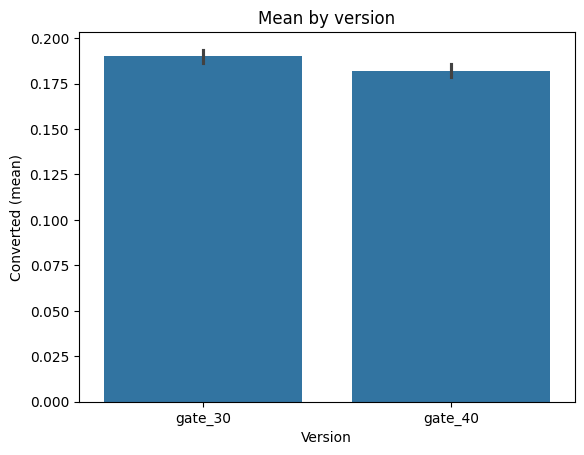

In [ ]:
sns.barplot(x=df['version'], y=df['retention_7'])
plt.title('Mean by version')
plt.xlabel('Version')
plt.ylabel('Converted (mean)');

2. Перевірте з допомогою z-тесту аналогічно до прикладу в лекції, чи дає якась з версій гри кращий показник `retention_7` на рівні значущості 0.05. Обчисліть також довірчі інтервали для двох вибірок. Виведіть результат у форматі:
```
z statistic: ...
p-value: ...
Довірчий інтервал 95% для групи control: [..., ...]
Довірчий інтервал 95% для групи treatment: [..., ...]
```
де замість `...` - обчислені значення. В якості висновка дайте відповідь на два питання:  
    1. чи є статистична значущою різниця між поведінкою користувачів у різних версіях гри?   
    2. чи перетинаються довірчі інтервали утримання користувачів з різних версій гри? Про що це каже?  
    
Зверніть увагу, в такому і схожому завданнях ми використовуєм `proportion` Z-тест. Це тому що в нас залежна змінна має бінарне значення (повернеться аби ні користувач, чи клікне або ні користувач в інших ситуаціях - всього два можливих значення в змінної: 0/1, True/False ). Якщо б ми вимірювали скажімо чи є стат. значущою різниця між вагою чоловіків і жінок в певній вибірці, ми б використовувавли функцію `statsmodels.stats.ztest`, бо залежна змінна `вага` є неперервною (тип float, замість типу int чи bool і тільки двох можливих значень).

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
gate_30_results = df[df['version'] == 'gate_30']['retention_7']
gate_40_results = df[df['version'] == 'gate_40']['retention_7']

In [ ]:
n_30 = gate_30_results.count()
n_40 = gate_40_results.count()
successes = [gate_30_results.sum(), gate_40_results.sum()]
nobs = [n_30, n_40]

z_stat, p_val = proportions_ztest(successes, nobs=nobs)
(lower_30, lower_40), (upper_30, upper_40) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.3f}')
print(f'Довірчий інтервал 95% для групи gate_30: [{lower_30:.3f}, {upper_40:.3f}]')
print(f'Довірчий інтервал 95% для групи gate_40: [{lower_40:.3f}, {upper_40:.3f}]')

z statistic: 3.16
p-value: 0.002
Довірчий інтервал 95% для групи gate_30: [0.187, 0.186]
Довірчий інтервал 95% для групи gate_40: [0.178, 0.186]


3. Є ще один тип тестів, який використовується для бінарної метрики як от "зробить юзер дію, чи ні" - тест [**Хі-квадрат**](https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/8-chi-squared-tests) (ще одне [пояснення](https://www.scribbr.com/statistics/chi-square-tests/) тесту з прикладами). В нього інші гіпотези Н0 і Н1 на відміну від z- та t-тестів. А також цей тест можна використовувати, якщо в нас більше за 2 досліджувані групи, тобто в нас не А/В тест, а А/B/C/D, наприклад.  

В **z- та t-тестах** (які відрізняються тим, що ми в першому не знаємо дисперсію генеральної сукупності, але якщо в нас великий набір даних, то ці два тести дають дуже схожі результати) **ми перевіряємо, чи є різниця у середніх показниках по групам користувачів**.  

А в **тесті Хі-квадрат ми перевіряємо чи є звʼязок між групою користувача і тим, чи він зробить цікаву нам дію**. Це ніби дослідження одного і того самого, але дещо різними способами. Для перевірки, можна виконувати кілька тестів (особливо, якщо один дає якийсь непереконливий результат типу р-значення 0.07 - наче і fail to regect H0 на рівні стат значущості 5%, але цікаво, що скажуть інші тести), тож, зробимо і ми тест хі-квадрат та порівняємо його результат з z-тестом.

Про різницю між тестами можна почитати ще [тут](https://stats.stackexchange.com/a/178860) - це просто пояснення користувача стековерфлоу, але там розумні люди сидять.

Для проведення хі-квадрат тесту скористаємось функцією з `scipy.stats` `chi2_contingency` для обчислення статистики хі-квадрат і р-значення для перевірки конкретної гіпотези. У цю функцію вам треба передати таблицю 2х2: кількість випадків для кожної версії гри і значення `retention_7`.

**Задача**: виконайте тест хі-квадрат на рівні значущості 5% аби визначити, чи є залежність між версією гри та тим, чи зайде гравець на 7ий день після встановлення гри.
Тут гіпотези наступні
- Н0: значення retention_7 не залежить від версії гри
- Н1: є залежність між версією гри і значенням retention_7

Виведіть p-значення та зробіть висновок.


In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
df_chi = df.groupby('version').retention_7.value_counts().reset_index()
df_chi

,version,retention_7,count
0,gate_30,False,36198
1,gate_30,True,8502
2,gate_40,False,37210
3,gate_40,True,8279


In [ ]:
table = pd.crosstab(df['version'], df['retention_7'])
table

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [ ]:
chi2_statistic, p_value, dof, exp = chi2_contingency(table)
chi2_statistic, p_value

(9.959086799559167, 0.0016005742679058301)

P-value  - 0.001, що набагато меншим за альфа -0.05, тобто відхиляємо нульову гіпотезу.
Існує залежність між версією гри і значенням retention_7